In [ ]:
# Based on abhijithjadhav Deepfake_detection_using_deep_learning repository

!pip3 install face_recognition

# Before running this, please change the RUNTIME to GPU (Runtime -> Change runtime type -> set hardware accelerator as GPU)
from google.colab import drive
drive.mount('/content/drive')

import os
import glob
import random
import numpy as np
import cv2
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch
from torch.autograd import Variable
import time
import sys
from torch import nn
from torchvision import models
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import threading
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

#Model with feature visualization
class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(weights=None) #Residual Network CNN
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))

class video_dataset(Dataset):
    def __init__(self,video_names,labels,sequence_length = 60,transform = None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.count = sequence_length

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)
        temp_video = video_path.split('/')[-1]
        #print(temp_video)

        label = self.labels.iloc[(self.labels.loc[self.labels["file"] == temp_video].index.values[0]),1]
        if(label == 'FAKE'):
          label = 0
        else:
          label = 1

        for i,frame in enumerate(self.frame_extract(video_path)):
          frames.append(self.transform(frame))
          if(len(frames) == self.count):
            break

        if len(frames) == 0:
          raise RuntimeError(f"No frames extracted from: {video_path}")

        frames = torch.stack(frames)
        frames = frames[:self.count]
        #print("length:" , len(frames), "label",label)
        return frames,label

    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path)
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image

def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(data_loader):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        targets = targets.long().to(device)
        inputs = inputs.to(device)

        _,outputs = model(inputs)
        loss  = criterion(outputs,targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
    return losses.avg,accuracies.avg

def test(epoch,model, data_loader ,criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred, true, probs_list = [], [], []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()

            _, outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy()  # probability for class=1
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs,targets.type(torch.cuda.LongTensor))
            _, p = torch.max(outputs,1)

            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            probs_list.extend(probs.tolist())
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true, pred, probs_list, losses.avg, accuracies.avg

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / batch_size

# --------------------------------------------
# CHECKPOINT HELPERS
# --------------------------------------------
def save_checkpoint(state, filename="/content/drive/MyDrive/csc490/code_and_datasets/checkpoints/best_model.pth"):
  os.makedirs(os.path.dirname(filename), exist_ok=True)
  torch.save(state, filename)
  print(f"\nCheckpoint saved: {filename}")

def load_checkpoint(model, optimizer, filename="/content/drive/MyDrive/csc490/code_and_datasets/checkpoints/best_model.pth"):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  if not os.path.isfile(filename):
    print(f"No checkpoint found at: {filename}")
    return 1, 0.0

  print(f"Loading checkpoint: {filename}")
  # use map_location to avoid GPU/CPU mismatch errors
  checkpoint = torch.load(filename, map_location=device)

  # defensive checks
  if "model_state" in checkpoint:
      model.load_state_dict(checkpoint["model_state"])
  else:
    # If checkpoint is just a state_dict (legacy), try loading it directly
    try:
      model.load_state_dict(checkpoint)
    except Exception as e:
      raise RuntimeError(f"Checkpoint does not contain 'model_state' and loading failed: {e}")

  if optimizer is not None and "optimizer_state" in checkpoint:
    try:
      optimizer.load_state_dict(checkpoint["optimizer_state"])
    except Exception as e:
      print(f"Warning: couldn't load optimizer state: {e}")

  start_epoch = checkpoint.get("epoch", 0) + 1
  best_acc = checkpoint.get("best_acc", 0.0)

  # move model to device explicitly
  model.to(device)

  print(f"Loaded checkpoint '{filename}' (resuming at epoch {start_epoch}, best_acc={best_acc})")
  return start_epoch, best_acc

# --------------------------------------------
# OUTPUT HELPERS
# --------------------------------------------
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
    print("Calculated Accuracy",calculated_acc*100)

def plot_loss(train_loss_avg,test_loss_avg,num_epochs):
  loss_train = train_loss_avg
  loss_val = test_loss_avg
  print(num_epochs)
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  if loss_val: # Only plot validation loss if it's not empty
    plt.plot(epochs[:len(loss_val)], loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

def plot_accuracy(train_accuracy,test_accuracy,num_epochs):
  loss_train = train_accuracy
  loss_val = test_accuracy
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training accuracy')
  if loss_val: # Only plot validation accuracy if it's not empty
    plt.plot(epochs[:len(loss_val)], loss_val, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

# --------------------------------------------
# Read filepaths from text files
# --------------------------------------------
def read_list(txt_path):
    with open(txt_path, 'r') as f:
        files = [line.strip() for line in f.readlines()]
    return files

# --------------------------------------------
# Assign labels (you may modify logic)
# Example: label = 0 for real, 1 for fake
# --------------------------------------------
def assign_label(path):
    path_low = path.lower()
    if "manipulated" in path_low or "deepfake" in path_low or "fake" in path_low:
        return 1
    return 0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566166 sha256=744e234cff29fd81c2fbc0ecf04c94998a87a2ce631caf9947a22e03672bad81
  Stored in directory: /root/.cache/pip/wheels/8f/47/c8/f44c5aebb7507f7c8a2c0bd23151d732d0f0bd6884ad4ac635
Successfully built face-recognition-models
Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/MyDrive/csc490/code_and_datasets/video_splits_output")
train_files = read_list("train.txt")
val_files   = read_list("val.txt")
test_files  = read_list("test.txt")

print("Loaded:")
print("Train:", len(train_files))
print("Val:", len(val_files))
print("Test:", len(test_files))

train_labels = pd.DataFrame({
    "file": [os.path.basename(p) for p in train_files],
    "label": [assign_label(p) for p in train_files]
})

val_labels = pd.DataFrame({
    "file": [os.path.basename(p) for p in val_files],
    "label": [assign_label(p) for p in val_files]
})

test_labels = pd.DataFrame({
    "file": [os.path.basename(p) for p in test_files],
    "label": [assign_label(p) for p in test_files]
})

print("Train Real:", sum(train_labels.label == 0), "Fake:", sum(train_labels.label == 1))
print("Val   Real:", sum(val_labels.label == 0),   "Fake:", sum(val_labels.label == 1))
print("Test  Real:", sum(test_labels.label == 0),  "Fake:", sum(test_labels.label == 1))

In [ ]:
# --------------------------------------------
# Define transforms
# --------------------------------------------
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# --------------------------------------------
# Create Dataset objects (video_dataset is your custom class)
# --------------------------------------------
train_data = video_dataset(
    video_names=train_files,
    labels=train_labels,
    sequence_length=10,
    transform=train_transforms
)

val_data = video_dataset(
    video_names=val_files,
    labels=val_labels,
    sequence_length=10,
    transform=test_transforms
)

test_data = video_dataset(
    video_names=test_files,
    labels=test_labels,
    sequence_length=10,
    transform=test_transforms
)

# --------------------------------------------
# DataLoaders
# --------------------------------------------
train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=4)
valid_loader = DataLoader(val_data, batch_size=4, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_data,  batch_size=4, shuffle=False, num_workers=4)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# # video_path = 'manipulated_sequences/DeepFakeDetection/c40/videos/26_25__talking_angry_couch__GJT740J9.mp4'
# # video_path = '/content/drive/MyDrive/faceforensics++/manipulated_sequences/DeepFakeDetection/c40/videos/26_25__talking_angry_couch__GJT740J9.mp4'
# video_path = 'Adversarial_attacked_sequences/QueryBasedAttacks/FlipSignAttack/DeepfakeDetectionSet/Epsilon0.01/04_01__walking_down_street_outside_angry__GBC7ZGDP.mp4'


# data = video_dataset(
#     video_names=[video_path],
#     labels=train_labels,
#     sequence_length=10,
#     transform=train_transforms
# )
# data.__getitem__(0)

In [ ]:
#learning rate
lr = 1e-5#0.001
#number of epochs
num_epochs = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)

# Create input tensor and move it to the same device
x = np.empty((1, 20, 3, 112, 112), dtype=np.float32)
tensor_input = torch.from_numpy(x).to(device)

# Run model
a, b = model(tensor_input)

#class_weights = torch.from_numpy(np.asarray([1,15])).type(torch.FloatTensor).cuda()
#criterion = nn.CrossEntropyLoss(weight = class_weights).cuda()
criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []

start_epoch, best_acc = 1, 0.0
for epoch in range(start_epoch, num_epochs+1):
    # ---- TRAIN ----
    l, acc = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)

    # ---- VALIDATION ----
    true, pred, probs, tl, t_acc = test(epoch, model, valid_loader, criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)

    # ---- SAVE BEST MODEL ----
    if t_acc > best_acc:
        best_acc = t_acc
        save_checkpoint({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "best_acc": best_acc
        })
        print(f"New best model saved with accuracy {best_acc:.2f}%")

NameError: name 'train_loader' is not defined

Loading checkpoint: /content/drive/MyDrive/csc490/code_and_datasets/checkpoints/no_pretraining_madry_style.pth
Loaded checkpoint '/content/drive/MyDrive/csc490/code_and_datasets/checkpoints/no_pretraining_madry_style.pth' (resuming at epoch 2, best_acc=100.0)
0


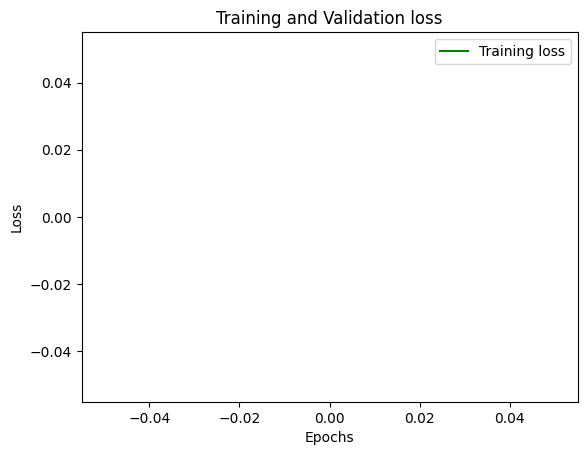

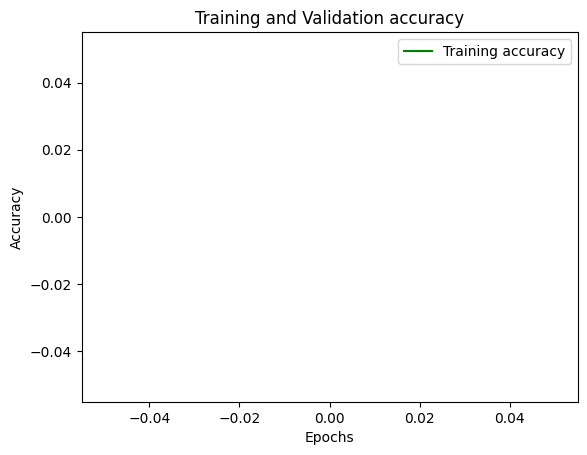

NameError: name 'true' is not defined

In [ ]:
load_checkpoint(model, optimizer, "/content/drive/MyDrive/csc490/code_and_datasets/checkpoints/no_pretraining_madry_style.pth")
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))

# Only print confusion matrix and calculate metrics if validation data exists
if true and pred and probs:
    print_confusion_matrix(true,pred)

    # F1 Score
    f1 = f1_score(true, pred)
    print(f"F1 Score: {f1:.4f}")

    # ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(true, probs)
    roc_auc = auc(fpr, tpr)
    print(f"AUC: {roc_auc:.4f}")

    # Plot ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("Skipping confusion matrix, F1 score, and ROC plot due to incomplete validation data. Please run the training loop to completion.")